#Image Captioning with Keras and TensorFlow

Image captioning is a technology that combines LSTM text generation with the computer vision powers of a convolutional neural network.  I first saw this technology in [Andrej Karpathy's Dissertation](https://cs.stanford.edu/people/karpathy/main.pdf). Images from his work are shown in Figure 10.ACAP.

**Figure 10.ACAP: Andrej Karpathy's Dissertation**
![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/karpathy_thesis.jpg "Captioning")

In this part, we will make use of LSTM and CNN to create a basic image captioning system. Transfer learning will be used to bring in these two projects:

* [Resnet50]
* [Glove]

Resnet50 is used to extract features from the images.  Glove is a set of Natural Language Processing (NLP) vectors for common words.

Figure 10.CAP-FLOW gives a high-level overview of captioning.

**Figure 10.CAP-FLOW: Captioning with a Neural Network**
![Captioning with a Neural Network](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/caption-1.png "Captioning with a Neural Network")



### Needed Data

You will need to download the following data and place it in a folder 

* [glove.6B] - Glove embeddings.
* [Flicker8k_Dataset](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip) - Flicker dataset.
* [Flicker8k_Text](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip)

Note, the original Flickr datasets are no longer available, but can be downloaded from [this article](https://machinelearningmastery.com/prepare-photo-caption-dataset-training-deep-learning-model/). 
We begin by importing the needed libraries.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [0]:
def readTextFile(path):
  with open(path) as f:
    captions=f.read()
  return captions  


In [0]:
captions  = readTextFile("/content/drive/My Drive/Colab Notebooks/New folder (4)/New folder (3)/Flickr8k.token.txt")

In [0]:
captions

Output hidden; open in https://colab.research.google.com to view.

In [0]:
captions=captions.split("\n")[:-1]

In [0]:
captions

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

In [0]:
print(len(captions))

40460


In [0]:
name,caption=captions[0].split("\t")

In [0]:
print(name,caption)

1000268201_693b08cb0e.jpg#0 A child in a pink dress is climbing up a set of stairs in an entry way .


In [0]:
descriptions={}
for x in captions:
  first,second=x.split("\t")
  name=first.split(".")[0]
  if descriptions.get(name) is None:
    descriptions[name]=[]
  descriptions[name].append(second)




In [0]:
descriptions

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [0]:
descriptions['2098418613_85a0c9afea']

['A brown chow mix dog is standing in front of a van with euro plats in the middle of a messy yard .',
 'A brown dog standing in a muddy yard .',
 'A brown dogs walks near a green van and some junk .',
 'A large brown dog stands in front of a green van in the yard of a house .',
 'A yellow dog is standing in front of a green car and next to a toilet .']

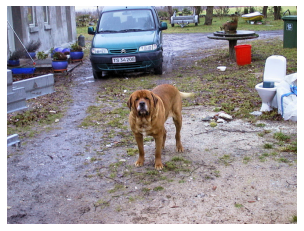

In [0]:
IMG_PATH = "/content/drive/My Drive/Colab Notebooks/New folder (4)/Images"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"/"+"2098418613_85a0c9afea.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Clean/Build Dataset From Flickr8k

We must pull in the Flickr dataset captions and clean them of extra whitespace, punctuation, and other distractions.

In [0]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence
    

In [0]:
clean_text("there is Brown dog in the House")

'there is brown dog in the house'

In [0]:
for k,caption in descriptions.items():
  for x in range(len(caption)):
    cap=clean_text(caption[x])
    caption[x]=cap
    
    

In [0]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [0]:
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

In [0]:
type(descriptions)

dict

In [0]:
descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with p

#MAKING THE VOCABULARY

In [0]:
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()

In [0]:
type(descriptions)

str

In [0]:
descriptions

Output hidden; open in https://colab.research.google.com to view.

In [0]:
json_acceptable_string = descriptions.replace("'","\"")


In [0]:
json_acceptable_string

Output hidden; open in https://colab.research.google.com to view.

In [0]:
descriptions = json.loads(json_acceptable_string)

In [0]:
type(descriptions)

dict

In [0]:
descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with p

In [0]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8424


In [0]:
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 373837


In [0]:
total_words

['child',
 'in',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 'girl',
 'going',
 'into',
 'wooden',
 'building',
 'little',
 'girl',
 'climbing',
 'into',
 'wooden',
 'playhouse',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 'little',
 'girl',
 'in',
 'pink',
 'dress',
 'going',
 'into',
 'wooden',
 'cabin',
 'black',
 'dog',
 'and',
 'spotted',
 'dog',
 'are',
 'fighting',
 'black',
 'dog',
 'and',
 'tri',
 'colored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 'black',
 'dog',
 'and',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',
 'other',
 'in',
 'the',
 'street',
 'two',
 'dogs',
 'of',
 'different',
 'breeds',
 'looking',
 'at',
 'each',
 'other',
 'on',
 'the',
 'road',
 'two',
 'dogs',
 'on',
 'pavement',
 'moving',
 'toward',
 'each',
 'other',
 'little',
 'girl',
 'covered',
 'in',
 'paint',
 'sits',
 'in',
 'front',

In [0]:
from collections import Counter
count=Counter(total_words)

In [0]:
type(count)

collections.Counter

In [0]:
freq=dict(count)

#Removing words which occur less than 10 times


In [0]:
sorted_freq_cnt = sorted(freq.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [0]:
len(total_words)

1845

#TRAIN AND TEST DATA

In [0]:
train_file_data = readTextFile("/content/drive/My Drive/Colab Notebooks/New folder (4)/New folder (3)/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/drive/My Drive/Colab Notebooks/New folder (4)/New folder (3)/Flickr_8k.testImages.txt")

In [0]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [0]:
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

#MODEL for image feature extraction

In [0]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102858752/102853048 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________

In [0]:
model_new = Model(model.input,model.layers[-2].output)

# ENCODING AND PREPROCESSING

In [0]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [0]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [0]:
encode_image(IMG_PATH+"/"+"1000268201_693b08cb0e.jpg")

array([0.04154301, 0.17076042, 0.29278612, ..., 0.05089623, 0.3132239 ,
       0.86007506], dtype=float32)

In [0]:
import os
if not os.path.exists("/content/drive/My Drive/Colab Notebooks/New folder (4)/New folder (3)/encoded_train_features.pkl"):
  start = time()
  encoding_train = {}
  #image_id -->feature_vector extracted from Resnet Image

  for ix,img_id in enumerate(train):
      img_path = IMG_PATH+"/"+img_id+".jpg"
      encoding_train[img_id] = encode_image(img_path)
      
  end_t = time()
  # Store everything to the disk 
  with open("/content/drive/My Drive/Colab Notebooks/New folder (4)/New folder (3)/encoded_train_features.pkl","wb") as f:
      pickle.dump(encoding_train,f)
  with open("/content/drive/My Drive/Colab Notebooks/New folder (4)/New folder (3)/encoded_train_features.pkl", "rb") as fp:
    encoding_train = pickle.load(fp)
else:
  with open("/content/drive/My Drive/Colab Notebooks/New folder (4)/New folder (3)/encoded_train_features.pkl", "rb") as fp:
    encoding_train = pickle.load(fp)

In [0]:
if not os.path.exists("/content/drive/My Drive/Colab Notebooks/New folder (4)/New folder (3)/encoded_test_features.pkl"):
  start = time()
  encoding_test = {}
  #image_id -->feature_vector extracted from Resnet Image

  for ix,img_id in enumerate(test):
      img_path = IMG_PATH+"/"+img_id+".jpg"
      encoding_test[img_id] = encode_image(img_path)
      
      if ix%100==0:
          print("Test Encoding in Progress Time step %d "%ix)
          
  end_t = time()
  print("Total Time Taken(test) :",end_t-start)
  with open("/content/drive/My Drive/Colab Notebooks/New folder (4)/New folder (3)/encoded_test_features.pkl","wb") as f:
      pickle.dump(encoding_test,f)
  with open("/content/drive/My Drive/Colab Notebooks/New folder (4)/New folder (3)/encoded_test_features.pkl", "rb") as fp:
    encoding_test = pickle.load(fp)

else:
  with open("/content/drive/My Drive/Colab Notebooks/New folder (4)/New folder (3)/encoded_test_features.pkl", "rb") as fp:
    encoding_test = pickle.load(fp)

#DICTIONARY FORMATION

In [0]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [0]:
print(len(idx_to_word))

1845


In [0]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [0]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


#DATA GENERATOR

In [0]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

#USING GLOVE MODEL

In [0]:
f = open("/content/drive/My Drive/Colab Notebooks/New folder (4)/glove.6B.50d.txt",encoding='utf8')

In [0]:
print(f)

<_io.TextIOWrapper name='/content/drive/My Drive/Colab Notebooks/New folder (4)/glove.6B.50d.txt' mode='r' encoding='utf8'>


In [0]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [0]:
f.close()

In [0]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [0]:
embedding_dim = 50
# Get 50-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_to_idx.items():
    #if i < max_words:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(1848, 50)

# MODEL COMBINING

In [0]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [0]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [0]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [0]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [0]:
len(train_descriptions)

6000

In [0]:
number_pics_per_batch=3
epochs = 20
batch_size = 3
steps = len(train_descriptions)//number_pics_per_batch


In [0]:
from keras import utils as np_ut

In [0]:

if not os.path.exists("/content/drive/My Drive/Colab Notebooks/New folder (4)/model.h5"):
  for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('/content/drive/My Drive/Colab Notebooks/New folder (4)/model.h5')
  
else:
  model = load_model('/content/drive/My Drive/Colab Notebooks/New folder (4)/model.h5')
    

In [0]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

#PREDICTIONS

In [0]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(10):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("/content/drive/My Drive/Colab Notebooks/New folder (4)/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    

Output hidden; open in https://colab.research.google.com to view.

##Visualization of features extracted from image

In [0]:
! pip install keract

In [0]:
def preprocess_image(img_path, model=None, rescale=255, resize=(224, 224)):
    """
    Preprocesses a given image for prediction with a trained model, with rescaling and resizing options
    
    Arguments:
            img_path: The path to the image file
            rescale: A float or integer indicating required rescaling. 
                    The image array will be divided (scaled) by this number.
            resize: A tuple indicating desired target size. 
                    This should match the input shape as expected by the model
    Returns:
            img: A processed image.
    """
    from keras.preprocessing.image import img_to_array, load_img
    import cv2
    import numpy as np

    assert type(img_path) == str, "Image path must be a string"
    assert (
        type(rescale) == int or type(rescale) == float
    ), "Rescale factor must be either a float or int"
    assert (
        type(resize) == tuple and len(resize) == 2
    ), "Resize target must be a tuple with two elements"

    img = load_img(img_path)
    img = img_to_array(img)
    img = img / float(rescale)
    img = cv2.resize(img, resize)
    if model != None:
        if len(model.input_shape) == 4:
            img = np.expand_dims(img, axis=0)

    return img

In [0]:
img_path = '/content/drive/My Drive/Colab Notebooks/New folder (4)/Images/54501196_a9ac9d66f2.jpg'

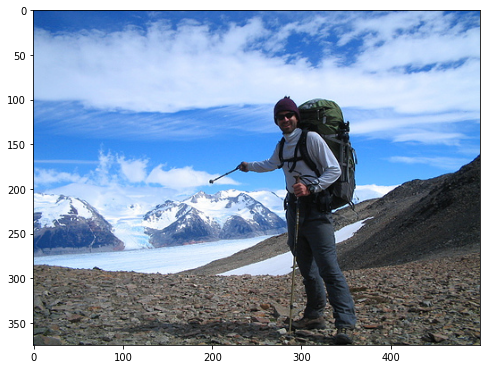

In [0]:
import matplotlib.pyplot as plt
import PIL
plt.figure(figsize=(8,7))
plt.imshow(PIL.Image.open(img_path))
plt.show()

In [0]:

x = preprocess_image(img_path=img_path,model=model_new,resize=(224,224))

In [0]:
from keract import get_activations
activations = get_activations(model_new, x)

#Output will be large due to many layers

Output will be display activations of  image after each layer

In [0]:
from keract import display_activations
display_activations(activations, save=False)

Output will be heatmap activations of  image after each layer

In [0]:

from keract import display_heatmaps
display_heatmaps(activations, x, save=False)